In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
img_rows, img_cols = 224, 224

my_MobileNet = MobileNet(
    weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

In [3]:
for layer in my_MobileNet.layers:
    layer.trainable=False

In [4]:
for i, layer in enumerate(my_MobileNet.layers):
    print("{}: {}, Trainable: {}".format(i, layer.__class__.__name__, layer.trainable))

0: InputLayer, Trainable: False
1: ZeroPadding2D, Trainable: False
2: Conv2D, Trainable: False
3: BatchNormalization, Trainable: False
4: ReLU, Trainable: False
5: DepthwiseConv2D, Trainable: False
6: BatchNormalization, Trainable: False
7: ReLU, Trainable: False
8: Conv2D, Trainable: False
9: BatchNormalization, Trainable: False
10: ReLU, Trainable: False
11: ZeroPadding2D, Trainable: False
12: DepthwiseConv2D, Trainable: False
13: BatchNormalization, Trainable: False
14: ReLU, Trainable: False
15: Conv2D, Trainable: False
16: BatchNormalization, Trainable: False
17: ReLU, Trainable: False
18: DepthwiseConv2D, Trainable: False
19: BatchNormalization, Trainable: False
20: ReLU, Trainable: False
21: Conv2D, Trainable: False
22: BatchNormalization, Trainable: False
23: ReLU, Trainable: False
24: ZeroPadding2D, Trainable: False
25: DepthwiseConv2D, Trainable: False
26: BatchNormalization, Trainable: False
27: ReLU, Trainable: False
28: Conv2D, Trainable: False
29: BatchNormalization, Trai

In [5]:
def addTopLayers(prev_model, num_classes):
    new_model = prev_model.output
    new_model = GlobalAveragePooling2D()(new_model)
    new_model = Dense(1024, activation='relu')(new_model)
    new_model = Dense(1024, activation='relu')(new_model)
    new_model = Dense(512, activation='relu')(new_model)
    new_model = Dense(num_classes, activation='softmax')(new_model)
    return new_model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [7]:
num_classes = 10
new_head = addTopLayers(my_MobileNet, num_classes)
model = Model(inputs=my_MobileNet.inputs, outputs=new_head)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [9]:
train_data_dir = os.getcwd()+'/monkey_breed/train/'
validation_data_dir = os.getcwd()+'/monkey_breed/validation/'

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

In [11]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)


validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


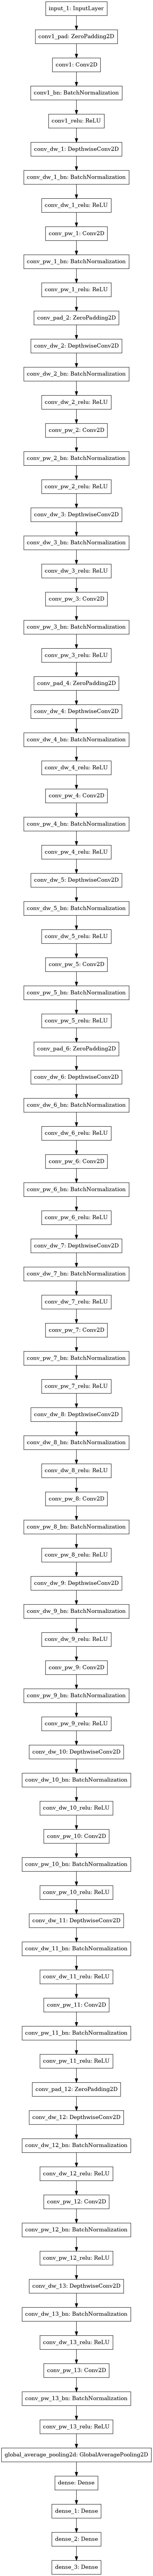

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [13]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

nb_train_samples = 1098
nb_validation_samples = 272
epochs = 20

In [14]:

checkpoint = ModelCheckpoint(os.getcwd() + "/Trained Models/monkey_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log_dir/model', histogram_freq=1)

callbacks = [earlystop, checkpoint, tensorboard_callback]

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
33/34 [============================>.] - ETA: 0s - loss: 3.7633 - accuracy: 0.2631
Epoch 00001: val_loss improved from inf to 1.00673, saving model to /home/amogh/Documents/Study/MLDL/Trained Models/monkey_cnn_1.h5
34/34 [==============================] - 40s 1s/step - loss: 3.6904 - accuracy: 0.2720 - val_loss: 1.0067 - val_accuracy: 0.6719
Epoch 2/20
33/34 [============================>.] - ETA: 0s - loss: 1.2577 - accuracy: 0.6132
Epoch 00002: val_loss improved from 1.00673 to 0.33484, saving model to /home/amogh/Documents/Study/MLDL/Trained Models/monkey_cnn_1.h5
34/34 [==============================] - 38s 1s/step - loss: 1.2401 - accuracy: 0.6191 - val_loss: 0.3348 - val_accuracy: 0.8711
Epoch 3/20
33/34 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.7485
Epoch 00003: val_loss improved from 0.33484 to 0.24053, saving model to /home/amogh/Documents/Study/MLDL/Trained Models/monkey_cnn_1.h5
34/34 [==============================] - 38s 1s/step - l

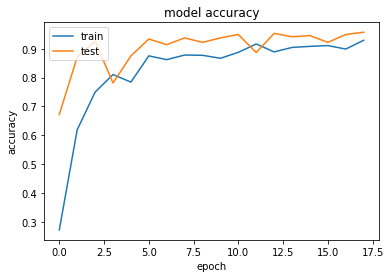

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

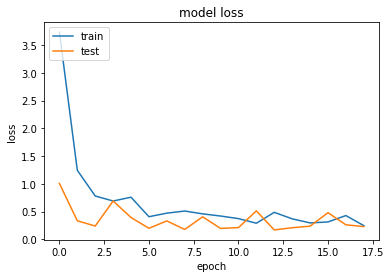

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
from tensorflow.keras.models import load_model
loaded_model = load_model(os.getcwd() + "/Trained Models/monkey_cnn_1.h5")

In [20]:
from os import listdir
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import numpy as np

path = validation_data_dir

  0%|          | 0/10 [00:00<?, ?it/s]

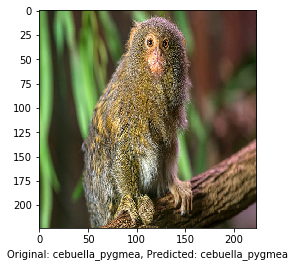

 10%|█         | 1/10 [00:00<00:07,  1.16it/s]

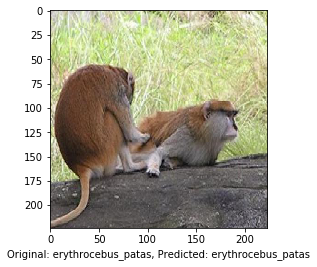

 20%|██        | 2/10 [00:01<00:05,  1.51it/s]

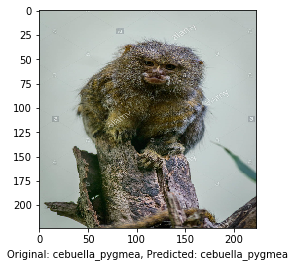

 30%|███       | 3/10 [00:01<00:03,  1.89it/s]

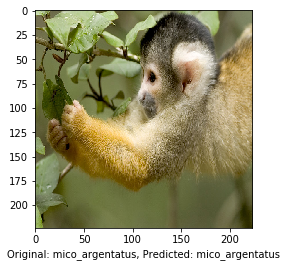

 40%|████      | 4/10 [00:01<00:02,  2.30it/s]

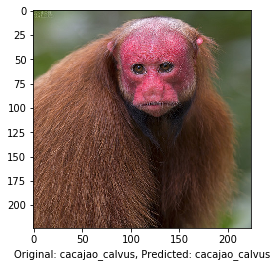

 50%|█████     | 5/10 [00:01<00:01,  2.75it/s]

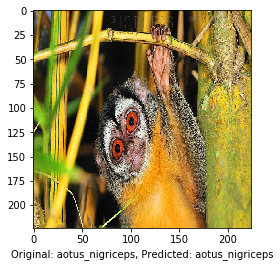

 60%|██████    | 6/10 [00:01<00:01,  3.20it/s]

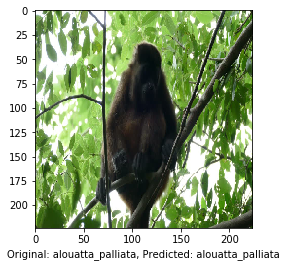

 70%|███████   | 7/10 [00:02<00:00,  3.64it/s]

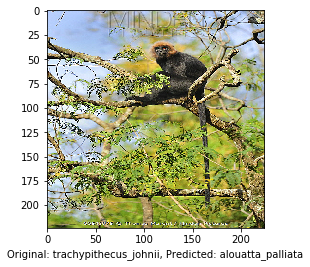

 80%|████████  | 8/10 [00:02<00:00,  4.00it/s]

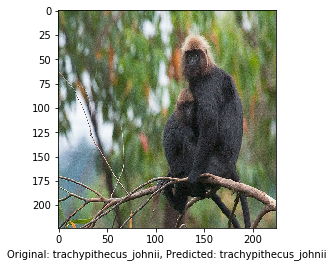

 90%|█████████ | 9/10 [00:02<00:00,  4.16it/s]

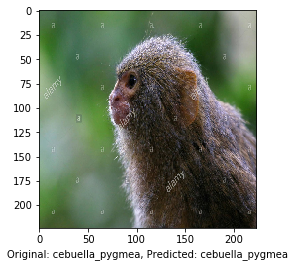

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


In [21]:
image_dimension = 224

monkey_breed_labels = {
    0: 'alouatta_palliata',
    1: 'erythrocebus_patas',
    2: 'cacajao_calvus',
    3: 'macaca_fuscata',
    4: 'cebuella_pygmea',
    5: 'cebus_capucinus',
    6: 'mico_argentatus',
    7: 'mico_argentatus',
    8: 'aotus_nigriceps',
    9: 'trachypithecus_johnii'
}

for i in tqdm(range(10)):
    monkey_names = os.listdir(path)
    monkey_names_folders = os.listdir(path)
    random_monkey_index = np.random.randint(0,len(monkey_names))
    monkey_name = monkey_names_folders[random_monkey_index]

    monkey_images_path = path + '/' + monkey_name
    monkey_images = os.listdir(monkey_images_path)
    random_monkey_image_index = np.random.randint(0,len(monkey_images))
    monkey_image = monkey_images[random_monkey_image_index]
    monkey_image_path = monkey_images_path + '/' + monkey_image
    
    result_image_array = image.img_to_array(image.load_img(monkey_image_path, target_size = (image_dimension, image_dimension)))
    normalized_result = result_image_array * 1./255
    expanded_result = np.expand_dims(normalized_result, axis=0)
    monkey_breed = np.argmax(loaded_model.predict(expanded_result), axis=1)
    predicted_label = monkey_breed_labels[int(monkey_breed)]
    
    plt.imshow(image.load_img(monkey_image_path, target_size = (image_dimension, image_dimension)))
    plt.xlabel('Original: {}, Predicted: {}'.format(monkey_breed_labels[int(monkey_name[-1])], predicted_label))
    plt.show()